In [2]:
# import of necessary modules
import numpy as np
import matplotlib.pyplot as plt
from numpy import loadtxt,sqrt,zeros,array,exp
from numpy import linalg
from scipy.integrate import odeint

In [3]:
# physical constants and parameters
hbarc = 197.326
M = (938.272 + 939.565) / 2.0 # averaged neutron/proton mass in MeV
units_factor = hbarc * hbarc / M
Nrows = 50  # 100: accurate, SRG takes some time! 50: less accurate, but faster

In [4]:
#arrays for uncoupled interaction channels
V = zeros([Nrows,Nrows],float)
Vmat = zeros([Nrows,Nrows],float)

#arrays for coupled interaction channels
Vcoupled = zeros([2*Nrows,2*Nrows],float)
Vmatcoupled = zeros([2*Nrows,2*Nrows],float)

#matrices for kinetic energy
Tkin = zeros([Nrows,Nrows],float)
Tkincoupled = zeros([2*Nrows,2*Nrows],float)

In [5]:
# read in nuclear interaction matrix elements for given uncoupled partial wave channels
def read_Vchiral(S, L, Lprime, J, T, Nrows):
    
    file = "store_VNN_TALENT/VNN_N3LO_EM500_SLLJT_%s%s%s%s%s_Np_%s_np.dat" % (S,L,Lprime,J,T,Nrows)
    mesh=np.genfromtxt(file,dtype=(float,float),skip_header=0,max_rows=Nrows)
    mesh_weights=mesh[:,0]
    mesh_points=mesh[:,1]
    
    Vread=np.genfromtxt(file,dtype=(float,float,float),skip_header=Nrows,max_rows=Nrows*Nrows)
    V = zeros([Nrows,Nrows],float)
    Vmat = zeros([Nrows,Nrows],float)
    Tkin = zeros([Nrows,Nrows],float)
    
    for i in range(Nrows):
        Tkin[i,i] = mesh_points[i] * mesh_points[i]
        for j in range(Nrows):
            V[i,j] = Vread[i*Nrows+j][2]        
            Vmat[i,j] = 2.0/np.pi*sqrt(mesh_weights[i]) * sqrt(mesh_weights[j]) * mesh_points[i] * mesh_points[j] * V[i,j]
            
    return [V, Vmat, Tkin, mesh_points, mesh_weights]

def read_AV18(S, L, Lprime, J, T, Nrows):
    
    file = "store_VNN_TALENT/VNN_AV18_SLLJT_%s%s%s%s%s_Np_%s_np.dat" % (S,L,Lprime,J,T,Nrows)
    mesh=np.genfromtxt(file,dtype=(float,float),skip_header=0,max_rows=Nrows)
    mesh_weights=mesh[:,0]
    mesh_points=mesh[:,1]
    
    Vread=np.genfromtxt(file,dtype=(float,float,float),skip_header=Nrows,max_rows=Nrows*Nrows)
    V = zeros([Nrows,Nrows],float)
    Vmat = zeros([Nrows,Nrows],float)
    Tkin = zeros([Nrows,Nrows],float)
    
    for i in range(Nrows):
        Tkin[i,i] = mesh_points[i] * mesh_points[i]
        for j in range(Nrows):
            V[i,j] = Vread[i*Nrows+j][2]        
            Vmat[i,j] = 2.0/np.pi*sqrt(mesh_weights[i]) * sqrt(mesh_weights[j]) * mesh_points[i] * mesh_points[j] * V[i,j]
            
    return [V, Vmat, Tkin, mesh_points, mesh_weights]

# read in nuclear interaction matrix elements for given coupled channel block for a given S,J,T
def read_Vchiral_coupled(S, J, T, Nrows):
    
    file00 = "store_VNN_TALENT/VNN_N3LO_EM500_SLLJT_%s%s%s%s%s_Np_%s_np.dat" % (S,J-1,J-1,J,T,Nrows)
    file01 = "store_VNN_TALENT/VNN_N3LO_EM500_SLLJT_%s%s%s%s%s_Np_%s_np.dat" % (S,J-1,J+1,J,T,Nrows)
    file10 = "store_VNN_TALENT/VNN_N3LO_EM500_SLLJT_%s%s%s%s%s_Np_%s_np.dat" % (S,J+1,J-1,J,T,Nrows)
    file11 = "store_VNN_TALENT/VNN_N3LO_EM500_SLLJT_%s%s%s%s%s_Np_%s_np.dat" % (S,J+1,J+1,J,T,Nrows)
    mesh=np.genfromtxt(file00,dtype=(float,float),skip_header=0,max_rows=Nrows)
    mesh_weights=mesh[:,0]
    mesh_points=mesh[:,1]
    
    Vread00=np.genfromtxt(file00,dtype=(float,float,float),skip_header=Nrows,max_rows=Nrows*Nrows)
    Vread01=np.genfromtxt(file01,dtype=(float,float,float),skip_header=Nrows,max_rows=Nrows*Nrows)
    Vread10=np.genfromtxt(file10,dtype=(float,float,float),skip_header=Nrows,max_rows=Nrows*Nrows)
    Vread11=np.genfromtxt(file11,dtype=(float,float,float),skip_header=Nrows,max_rows=Nrows*Nrows)
    
    V00 = zeros([Nrows,Nrows],float)
    V01 = zeros([Nrows,Nrows],float)
    V10 = zeros([Nrows,Nrows],float)
    V11 = zeros([Nrows,Nrows],float)
    Vcoupled = zeros([2*Nrows,2*Nrows],float)
    
    Vmat00 = zeros([Nrows,Nrows],float)
    Vmat01 = zeros([Nrows,Nrows],float)
    Vmat10 = zeros([Nrows,Nrows],float)
    Vmat11 = zeros([Nrows,Nrows],float)
    Vmatcoupled = zeros([2*Nrows,2*Nrows],float)
    Tkincoupled = zeros([2*Nrows,2*Nrows],float)
    
    for i in range(Nrows):
        Tkincoupled[i,i] = mesh_points[i] * mesh_points[i]
        Tkincoupled[i+Nrows,i+Nrows] = mesh_points[i] * mesh_points[i]
        for j in range(Nrows):
            V00[i,j] = Vread00[i*Nrows+j][2]
            V01[i,j] = Vread01[i*Nrows+j][2]
            V10[i,j] = Vread10[i*Nrows+j][2]
            V11[i,j] = Vread11[i*Nrows+j][2]
            Vcoupled[i,j] = V00[i,j]
            Vcoupled[i,j+Nrows] = V01[i,j]
            Vcoupled[i+Nrows,j] = V10[i,j]
            Vcoupled[i+Nrows,j+Nrows] = V11[i,j]
            
            Vmat00[i,j] = 2.0/np.pi*sqrt(mesh_weights[i]) * sqrt(mesh_weights[j]) * mesh_points[i] * mesh_points[j] * V00[i,j]
            Vmat01[i,j] = 2.0/np.pi*sqrt(mesh_weights[i]) * sqrt(mesh_weights[j]) * mesh_points[i] * mesh_points[j] * V01[i,j]
            Vmat10[i,j] = 2.0/np.pi*sqrt(mesh_weights[i]) * sqrt(mesh_weights[j]) * mesh_points[i] * mesh_points[j] * V10[i,j]
            Vmat11[i,j] = 2.0/np.pi*sqrt(mesh_weights[i]) * sqrt(mesh_weights[j]) * mesh_points[i] * mesh_points[j] * V11[i,j]
            Vmatcoupled[i,j] = Vmat00[i,j]
            Vmatcoupled[i,j+Nrows] = Vmat01[i,j]
            Vmatcoupled[i+Nrows,j] = Vmat10[i,j]
            Vmatcoupled[i+Nrows,j+Nrows] = Vmat11[i,j]
            
    return [V00, V01, V10, V11, Vmat00, Vmat01, Vmat10, Vmat11, Vcoupled, Vmatcoupled, Tkincoupled, mesh_points, mesh_weights]

# read in nuclear interaction matrix elements for given coupled channel block for a given S,J,T
def read_AV18_coupled(S, J, T, Nrows):
    
    file00 = "store_VNN_TALENT/VNN_AV18_SLLJT_%s%s%s%s%s_Np_%s_np.dat" % (S,J-1,J-1,J,T,Nrows)
    file01 = "store_VNN_TALENT/VNN_AV18_SLLJT_%s%s%s%s%s_Np_%s_np.dat" % (S,J-1,J+1,J,T,Nrows)
    file10 = "store_VNN_TALENT/VNN_AV18_SLLJT_%s%s%s%s%s_Np_%s_np.dat" % (S,J+1,J-1,J,T,Nrows)
    file11 = "store_VNN_TALENT/VNN_AV18_SLLJT_%s%s%s%s%s_Np_%s_np.dat" % (S,J+1,J+1,J,T,Nrows)
    mesh=np.genfromtxt(file00,dtype=(float,float),skip_header=0,max_rows=Nrows)
    mesh_weights=mesh[:,0]
    mesh_points=mesh[:,1]
    
    Vread00=np.genfromtxt(file00,dtype=(float,float,float),skip_header=Nrows,max_rows=Nrows*Nrows)
    Vread01=np.genfromtxt(file01,dtype=(float,float,float),skip_header=Nrows,max_rows=Nrows*Nrows)
    Vread10=np.genfromtxt(file10,dtype=(float,float,float),skip_header=Nrows,max_rows=Nrows*Nrows)
    Vread11=np.genfromtxt(file11,dtype=(float,float,float),skip_header=Nrows,max_rows=Nrows*Nrows)
    
    V00 = zeros([Nrows,Nrows],float)
    V01 = zeros([Nrows,Nrows],float)
    V10 = zeros([Nrows,Nrows],float)
    V11 = zeros([Nrows,Nrows],float)
    Vcoupled = zeros([2*Nrows,2*Nrows],float)
    
    Vmat00 = zeros([Nrows,Nrows],float)
    Vmat01 = zeros([Nrows,Nrows],float)
    Vmat10 = zeros([Nrows,Nrows],float)
    Vmat11 = zeros([Nrows,Nrows],float)
    Vmatcoupled = zeros([2*Nrows,2*Nrows],float)
    Tkincoupled = zeros([2*Nrows,2*Nrows],float)
    
    for i in range(Nrows):
        Tkincoupled[i,i] = mesh_points[i] * mesh_points[i]
        Tkincoupled[i+Nrows,i+Nrows] = mesh_points[i] * mesh_points[i]
        for j in range(Nrows):
            V00[i,j] = Vread00[i*Nrows+j][2]
            V01[i,j] = Vread01[i*Nrows+j][2]
            V10[i,j] = Vread10[i*Nrows+j][2]
            V11[i,j] = Vread11[i*Nrows+j][2]
            Vcoupled[i,j] = V00[i,j]
            Vcoupled[i,j+Nrows] = V01[i,j]
            Vcoupled[i+Nrows,j] = V10[i,j]
            Vcoupled[i+Nrows,j+Nrows] = V11[i,j]
            
            Vmat00[i,j] = 2.0/np.pi*sqrt(mesh_weights[i]) * sqrt(mesh_weights[j]) * mesh_points[i] * mesh_points[j] * V00[i,j]
            Vmat01[i,j] = 2.0/np.pi*sqrt(mesh_weights[i]) * sqrt(mesh_weights[j]) * mesh_points[i] * mesh_points[j] * V01[i,j]
            Vmat10[i,j] = 2.0/np.pi*sqrt(mesh_weights[i]) * sqrt(mesh_weights[j]) * mesh_points[i] * mesh_points[j] * V10[i,j]
            Vmat11[i,j] = 2.0/np.pi*sqrt(mesh_weights[i]) * sqrt(mesh_weights[j]) * mesh_points[i] * mesh_points[j] * V11[i,j]
            Vmatcoupled[i,j] = Vmat00[i,j]
            Vmatcoupled[i,j+Nrows] = Vmat01[i,j]
            Vmatcoupled[i+Nrows,j] = Vmat10[i,j]
            Vmatcoupled[i+Nrows,j+Nrows] = Vmat11[i,j]
            
    return [V00, V01, V10, V11, Vmat00, Vmat01, Vmat10, Vmat11, Vcoupled, Vmatcoupled, Tkincoupled, mesh_points, mesh_weights]

In [6]:
# read in particular uncoupled or coupled matrix elements
S = 0
L = 0
Lprime = 0
J = 0
T = 1

[V, Vmat, Tkin, mesh_points, mesh_weights] = read_Vchiral(S,L,Lprime,J,T,Nrows)
# [V, Vmat, Tkin, mesh_points, mesh_weights] = read_AV18(S,L,Lprime,J,T,Nrows)

S = 1
J = 1
T = 0

[V00, V01, V10, V11, Vmat00, Vmat01, Vmat10, Vmat11, Vcoupled, Vmatcoupled, Tkincoupled, mesh_points, mesh_weights] = read_Vchiral_coupled(S,J,T,Nrows)
# [V00, V01, V10, V11, Vmat00, Vmat01, Vmat10, Vmat11, Vcoupled, Vmatcoupled, Tkincoupled, mesh_points, mesh_weights] = read_AV18_coupled(S,J,T,Nrows)

In [7]:
#visualize the matrix elements in an uncoupled channel
def plot_V(V, maxindex):
    fig, (ax) = plt.subplots(nrows=1,ncols=1,figsize=(5, 5))
    maxabs = max(abs(V[:maxindex,:maxindex].min()),abs(abs(V)[:maxindex,:maxindex].max()))
    ax.set_xlabel("p [fm^{-1}]")
    ax.set_ylabel("p' [fm^{-1}]")
    ax.set_aspect('equal')
    im = ax.pcolormesh(mesh_points[:maxindex], mesh_points[:maxindex], V[:maxindex,:maxindex], vmin = -maxabs, vmax = maxabs, cmap='jet',rasterized=True)

#visualize the matrix elements in a coupled channel
def plot_V_coupled(V00, V01, V10, V11, maxindex):
    fig, (ax) = plt.subplots(nrows=2,ncols=2,figsize=(10, 10))
    maxabs = max(abs(V00[:maxindex,:maxindex].min()),abs(abs(V00)[:maxindex,:maxindex].max()))
    ax[0,0].set_aspect('equal')
    ax[0,0].set_xlabel("p [fm^{-1}]")
    ax[0,0].set_ylabel("p' [fm^{-1}]")
    ax[0,1].set_xlabel("p [fm^{-1}]")
    ax[0,1].set_ylabel("p' [fm^{-1}]")
    ax[1,0].set_xlabel("p [fm^{-1}]")
    ax[1,0].set_ylabel("p' [fm^{-1}]")
    ax[1,1].set_xlabel("p [fm^{-1}]")
    ax[1,1].set_ylabel("p' [fm^{-1}]")
    im = ax[0,0].pcolormesh(mesh_points[:maxindex], mesh_points[:maxindex], V00[:maxindex,:maxindex], vmin = -maxabs, vmax = maxabs, cmap='jet',rasterized=True)
    im = ax[0,1].pcolormesh(mesh_points[:maxindex], mesh_points[:maxindex], V01[:maxindex,:maxindex], vmin = -maxabs, vmax = maxabs, cmap='jet',rasterized=True)
    im = ax[1,0].pcolormesh(mesh_points[:maxindex], mesh_points[:maxindex], V10[:maxindex,:maxindex], vmin = -maxabs, vmax = maxabs, cmap='jet',rasterized=True)
    im = ax[1,1].pcolormesh(mesh_points[:maxindex], mesh_points[:maxindex], V11[:maxindex,:maxindex], vmin = -maxabs, vmax = maxabs, cmap='jet',rasterized=True)

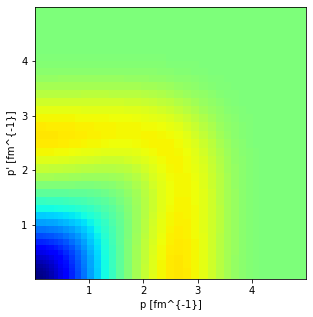

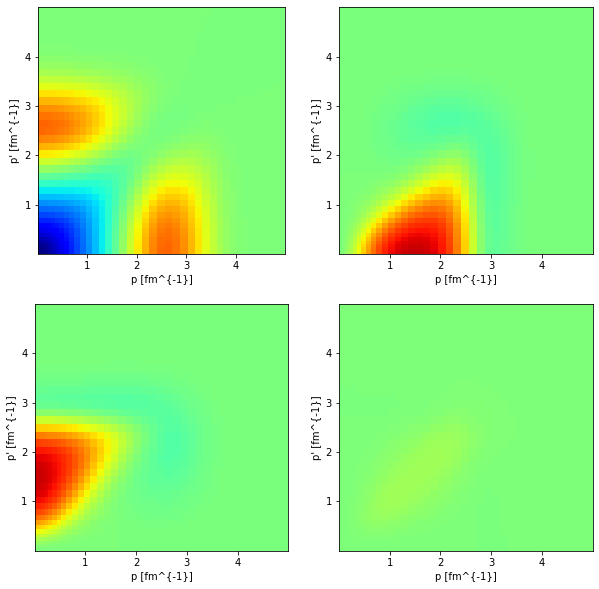

In [8]:
plot_V(V,Nrows)
plot_V_coupled(V00,V01,V10,V11,Nrows)

In [9]:
# computation of deuteron binding energy via diagonalization
def solve_deuteron(VmatSS, VmatSD, VmatDS, VmatDD, Nrows):  
    
    Hmat = zeros([2*Nrows,2*Nrows],float)
    for i in range(Nrows):
        Hmat[i,i] += units_factor * mesh_points[i] * mesh_points[i]
        Hmat[i + Nrows,i + Nrows] += units_factor * mesh_points[i] * mesh_points[i]

        for j in range(Nrows):
            Hmat[i,j] += units_factor * VmatSS[i,j]
            Hmat[i,j + Nrows] += units_factor * VmatSD[i,j]
            Hmat[i + Nrows,j] += units_factor * VmatDS[i,j]
            Hmat[i + Nrows,j + Nrows] += units_factor * VmatDD[i,j]
    
    w, v = linalg.eig(Hmat)
    idx = np.argsort(w)
    
    w = w[idx]
    psi_S = zeros(Nrows,float)
    psi_D = zeros(Nrows,float)
    for i in range(Nrows):
        psi_S[i] = v[i,idx[0]] 
        psi_D[i] = v[i+Nrows,idx[0]]
    return [w[0],psi_S,psi_D]

# computation of deuteron binding energy via diagonalization with an additional cut on the maximum momentum value
def solve_deuteron_cut(VmatSS, VmatSD, VmatDS, VmatDD, Nrows, pmax):  
    
    Nsize = 0
    while mesh_points[Nsize] < pmax:
        Nsize+=1
    
    Hmat = zeros([2*Nsize,2*Nsize],float)
    for i in range(Nsize):
        Hmat[i,i] += units_factor * mesh_points[i] * mesh_points[i]
        Hmat[i + Nsize,i + Nsize] += units_factor * mesh_points[i] * mesh_points[i]

        for j in range(Nsize):
            Hmat[i,j] += units_factor * VmatSS[i,j]
            Hmat[i,j + Nsize] += units_factor * VmatSD[i,j]
            Hmat[i + Nsize,j] += units_factor * VmatDS[i,j]
            Hmat[i + Nsize,j + Nsize] += units_factor * VmatDD[i,j]
    
    w, v = linalg.eig(Hmat)
    idx = np.argsort(w)
    w = w[idx]
    psi_S = zeros(Nsize,float)
    psi_D = zeros(Nsize,float)
    for i in range(Nsize):
        psi_S[i] = v[i,idx[0]] 
        psi_D[i] = v[i+Nsize,idx[0]]
        
    return [w[0],psi_S,psi_D]

In [10]:
print(solve_deuteron(Vmat00, Vmat01, Vmat10, Vmat11, Nrows) [0],solve_deuteron_cut(Vmat00, Vmat01, Vmat10, Vmat11, Nrows,4) [0])

-2.2245557279441885 -2.224217089518148


In [11]:
[Edeut, psi_S, psi_D] = solve_deuteron(Vmat00, Vmat01, Vmat10, Vmat11, Nrows)
norm_S = 0.0
norm_D = 0.0
for i in range(Nrows):
    norm_S += psi_S[i]*psi_S[i]
    norm_D += psi_D[i]*psi_D[i]
    
print("E_d=",Edeut,"\n|psi_S|^2=",norm_S,"\n|psi_D|^2=",norm_D,"\n|psi|^2=",norm_S+norm_D,"\nP_D=",100*norm_D/(norm_S+norm_D),"%")

E_d= -2.2245557279441885 
|psi_S|^2= 0.9548582988116291 
|psi_D|^2= 0.045141701188370555 
|psi|^2= 0.9999999999999997 
P_D= 4.5141701188370575 %


In [12]:
#routines for computing phase shifts by solving the Lippmann Schwinger equation

# offset for subtracting the pole
eps = 1e-3

#computation of phase shifts in uncoupled channels
def counterterm(pmax, pole):
    return np.arctanh(pole/pmax)/pole

def compute_phase_shifts(K,i):
    return 180.0/np.pi*np.arctan(-mesh_points[i]*K[i,i])

#note that ambiguity regarding the brach of arctan exists, make sure that solution is continuous as a function of energy
def compute_phase_shifts_coupled(K,i):  
    epsilon = np.arctan(2*K[i,i+Nrows]/(K[i,i] - K[i+Nrows,i+Nrows]))/2.0
    r_epsilon = (K[i,i] - K[i+Nrows,i+Nrows])/(np.cos(2*epsilon))
    delta_a = - np.arctan(mesh_points[i] * (K[i,i] + K[i+Nrows,i+Nrows] + r_epsilon)/2.0)
    delta_b = - np.arctan(mesh_points[i] * (K[i,i] + K[i+Nrows,i+Nrows] - r_epsilon)/2.0)
                      
    epsilonbar = np.arcsin(np.sin(2*epsilon)*np.sin(delta_a - delta_b))/2.0
    delta_1 = 180.0/np.pi * (delta_a + delta_b + np.arcsin(np.tan(2*epsilonbar)/(np.tan(2*epsilon))))/2.0
    delta_2 = 180.0/np.pi * (delta_a + delta_b - np.arcsin(np.tan(2*epsilonbar)/(np.tan(2*epsilon))))/2.0
    
    epsilonbar *= -180.0/np.pi
    return [delta_1,delta_2,epsilonbar]
                          
def delta(i,j):
    if (i==j):
        return 1
    else:
        return 0

def Elab(p):
    return 2*p**2*hbarc**2/M

def mom(E):
    return np.sqrt(M*E/2/hbarc**2)
    
def compute_K_matrix(V, Nrows, pmax):  
    A = zeros([Nrows+1,Nrows+1],float)
    K = zeros([Nrows,Nrows],float)
    
    for x in range(Nrows):
        pole = mesh_points[x] + eps
        
        for i in range(Nrows):
            for j in range(Nrows):
                A[i,j] = delta(i,j) - 2.0/np.pi * mesh_weights[j]* V[i,j] * mesh_points[j]**2 / (pole**2 - mesh_points[j]**2)
        
        sum = 0.0
        for i in range(Nrows):
            sum += mesh_weights[i]/(pole**2 - mesh_points[i]**2)

        for i in range(Nrows):
            A[Nrows,i] = - 2.0/np.pi * mesh_weights[i] * mesh_points[i]**2 * V[x,i]/(pole**2 - mesh_points[i]**2)
            A[i,Nrows] = + 2.0/np.pi * V[i,x] * pole**2 * (sum - counterterm(pmax,pole))

        A[Nrows,Nrows] = 1 + 2.0/np.pi * V[x,x] * pole**2 * (sum - counterterm(pmax,pole))

        bvec = zeros([Nrows+1],float)
        for i in range(Nrows):
            bvec[i] = V[i,x]
        bvec[Nrows] = V[x,x]
        
        xvec = np.linalg.solve(A, bvec)

        for i in range(Nrows):
            K[i,x] = xvec[i]

    return K


def compute_K_matrix_coupled(V00, V01, V10, V11, Nrows, pmax):  
    A = zeros([2*Nrows+2,2*Nrows+2],float)
    K = zeros([2*Nrows,2*Nrows],float)
    
    for x in range(Nrows):
        pole = mesh_points[x] + eps
        
        for i in range(Nrows):
            for j in range(Nrows):
                A[i,j]             = delta(i,j) - 2.0/np.pi * mesh_weights[j]* V00[i,j] * mesh_points[j]**2 / (pole**2 - mesh_points[j]**2)
                A[i,j+Nrows]       =            - 2.0/np.pi * mesh_weights[j]* V01[i,j] * mesh_points[j]**2 / (pole**2 - mesh_points[j]**2)
                A[i+Nrows,j]       =            - 2.0/np.pi * mesh_weights[j]* V10[i,j] * mesh_points[j]**2 / (pole**2 - mesh_points[j]**2)
                A[i+Nrows,j+Nrows] = delta(i,j) - 2.0/np.pi * mesh_weights[j]* V11[i,j] * mesh_points[j]**2 / (pole**2 - mesh_points[j]**2)
                
        sum = 0.0
        for i in range(Nrows):
            sum += mesh_weights[i]/(pole**2 - mesh_points[i]**2)

        for i in range(Nrows):
            A[2*Nrows,i] = - 2.0/np.pi * mesh_weights[i] * mesh_points[i]**2 * V00[x,i]/(pole**2 - mesh_points[i]**2)
            A[i,2*Nrows] = + 2.0/np.pi * V00[i,x] * pole**2 * (sum - counterterm(pmax,pole))
            
            A[2*Nrows,i+Nrows] = - 2.0/np.pi * mesh_weights[i] * mesh_points[i]**2 * V01[x,i]/(pole**2 - mesh_points[i]**2)
            A[i,2*Nrows+1]     = + 2.0/np.pi * V01[i,x] * pole**2 * (sum - counterterm(pmax,pole))
            
            A[2*Nrows+1,i]     = - 2.0/np.pi * mesh_weights[i] * mesh_points[i]**2 * V10[x,i]/(pole**2 - mesh_points[i]**2)
            A[i+Nrows,2*Nrows] = + 2.0/np.pi * V10[i,x] * pole**2 * (sum - counterterm(pmax,pole))
            
            A[2*Nrows+1,i+Nrows] = - 2.0/np.pi * mesh_weights[i] * mesh_points[i]**2 * V11[x,i]/(pole**2 - mesh_points[i]**2)
            A[i+Nrows,2*Nrows+1] = + 2.0/np.pi * V11[i,x] * pole**2 * (sum - counterterm(pmax,pole))

        A[2*Nrows,2*Nrows]     = 1 + 2.0/np.pi * V00[x,x] * pole**2 * (sum - counterterm(pmax,pole))
        A[2*Nrows,2*Nrows+1]   =   + 2.0/np.pi * V01[x,x] * pole**2 * (sum - counterterm(pmax,pole))
        A[2*Nrows+1,2*Nrows]   =   + 2.0/np.pi * V10[x,x] * pole**2 * (sum - counterterm(pmax,pole))
        A[2*Nrows+1,2*Nrows+1] = 1 + 2.0/np.pi * V11[x,x] * pole**2 * (sum - counterterm(pmax,pole))

        bvec = zeros([2*Nrows+2,2],float)
        for i in range(Nrows):
            bvec[i,0] = V00[i,x]
            bvec[i,1] = V01[i,x]
            bvec[i+Nrows,0] = V10[i,x]
            bvec[i+Nrows,1] = V11[i,x]
            
        bvec[2*Nrows,0] = V00[x,x]
        bvec[2*Nrows,1] = V01[x,x]
        bvec[2*Nrows+1,0] = V10[x,x]
        bvec[2*Nrows+1,1] = V11[x,x]
        
        xvec = np.linalg.solve(A, bvec)

        for i in range(Nrows):
            K[i,x]             = xvec[i,0]
            K[i,x+Nrows]       = xvec[i,1]
            K[i+Nrows,x]       = xvec[i+Nrows,0]
            K[i+Nrows,x+Nrows] = xvec[i+Nrows,1]

    return K

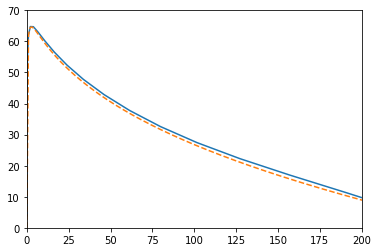

In [13]:
# study phase shifts in uncoupled channel
K = compute_K_matrix(V,Nrows,6.5)
phase_shifts = np.array([compute_phase_shifts(K,i) for i in range(Nrows)])
energy = Elab(mesh_points)

# read in phase shiftsfrom NN-Online
exp_phase=np.genfromtxt("delta_1S0.dat",dtype=(float,float))

plt.plot(energy,phase_shifts)
plt.plot(exp_phase[:,0],exp_phase[:,1],ls='dashed')
plt.xlim([0, 200])
plt.ylim([0, 70])
plt.show()

In [14]:
# phase shiifts in coupled channel
K = compute_K_matrix_coupled(V00,V01,V10,V11,Nrows,6.5)
phase_shifts_coupled = np.array([compute_phase_shifts_coupled(K,i) for i in range(Nrows)])
energy = Elab(mesh_points)

# read in phase shiftsfrom NN-Online
exp_phase=np.genfromtxt("delta_3S1.dat",dtype=(float,float))

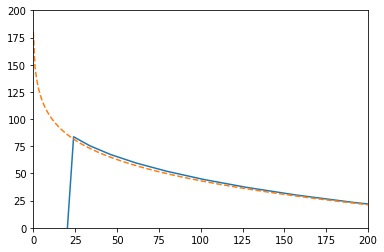

In [15]:
plt.plot(energy,phase_shifts_coupled[:,0])
plt.plot(exp_phase[:,0],exp_phase[:,1],ls='dashed')
plt.xlim([0, 200])
plt.ylim([0, 200])
plt.show()

In [16]:
# commutator, arguments A and B matrices
def commutator(A,B):
    return np.matmul(A,B)-np.matmul(B,A)

# commutator including reshaping to [Nrows,Nrows] matrices, arguments A and B are 1d arrays
def commutator_reshape(A,B,Nrows):
    A_reshape = np.reshape(A,(Nrows,Nrows))
    B_reshape = np.reshape(B,(Nrows,Nrows))
    return np.matmul(A_reshape,B_reshape)-np.matmul(B_reshape,A_reshape)

# commutator for coupled channels including reshaping to [Nrows,Nrows] matrices, arguments A and B are 1d arrays
def commutator_reshape_coupled(A,B,Nrows):
    A_reshape = np.reshape(A,(2*Nrows,2*Nrows))
    B_reshape = np.reshape(B,(2*Nrows,2*Nrows))
    return np.matmul(A_reshape,B_reshape)-np.matmul(B_reshape,A_reshape)

In [17]:
# alternative flow parameter, has dimensions of momentum
def Lambda(s):
    return pow(s,-1/4)

In [18]:
# right hand side of SRG flow equation, implementation of double commutators for uncoupled and coupled cases
def dVds(V, s, Nrows, Tkin):
    V_reshape = np.reshape(V,(Nrows,Nrows));
    ret = np.reshape(commutator_reshape(commutator_reshape(Tkin,V_reshape,Nrows),Tkin+V_reshape,Nrows),V.size)
    return ret

def dVds_coupled(Vcoupled, s, Nrows, Tkincoupled):
    Vcoupled_reshape = np.reshape(Vcoupled,(2*Nrows,2*Nrows))
    ret = np.reshape(commutator_reshape_coupled(commutator_reshape_coupled(Tkincoupled,Vcoupled_reshape,Nrows),Tkincoupled+Vcoupled_reshape,Nrows),Vcoupled.size)
    return ret

In [19]:
# solve uncoupled SRG equations
Ns = 10
s = np.logspace(-4, -0.8, Ns)
sol = odeint(dVds, np.reshape(Vmat,Vmat.size), s, args=(Nrows, Tkin), rtol=1e-5, atol=1e-5)
Lambda(s)

array([10.        ,  8.14912747,  6.64082785,  5.41169527,  4.41005945,
        3.59381366,  2.92864456,  2.38658979,  1.94486244,  1.58489319])

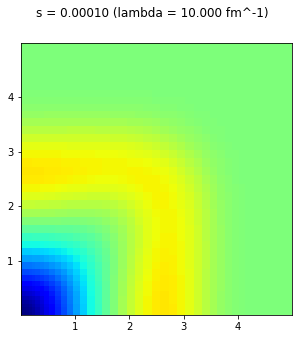

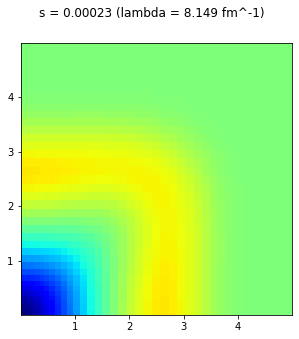

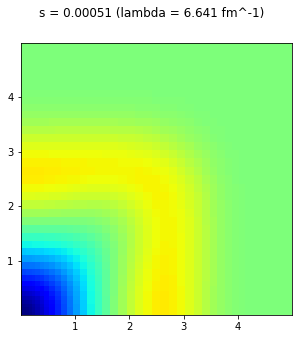

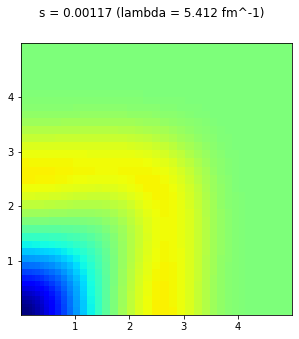

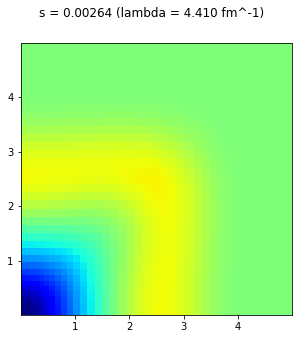

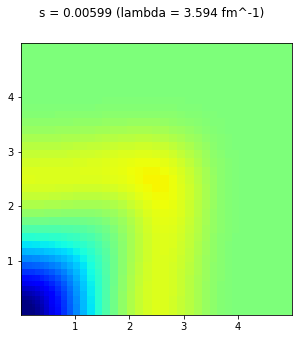

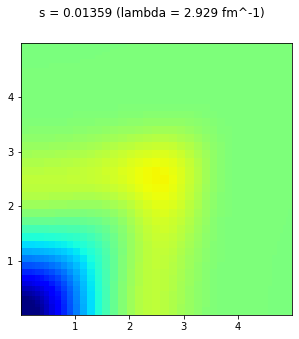

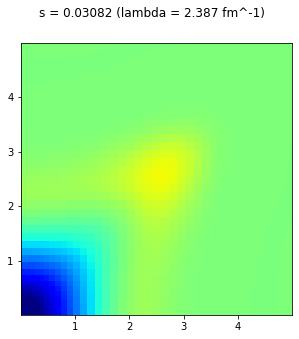

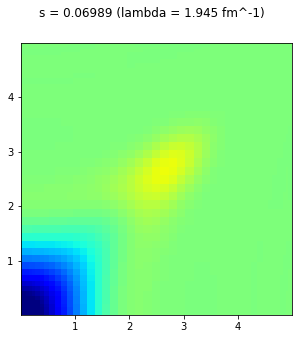

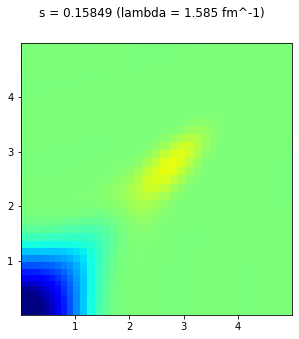

In [20]:
#visualize matrix elements of uncoupled channel as function of RG resolution scale
x0 = np.reshape(sol[0],(Nrows,Nrows))
PhaseSpace = zeros([Nrows,Nrows])

for i in range(Nrows):
    for j in range(Nrows):
        PhaseSpace[i,j] = 2.0/np.pi*sqrt(mesh_weights[i]) * sqrt(mesh_weights[j]) * mesh_points[i] * mesh_points[j]
        
maxindex = Nrows
maxabs = max(abs((x0/PhaseSpace)[:maxindex,:maxindex].min()),abs(abs((x0/PhaseSpace)[:maxindex,:maxindex].max())))
for i in range(Ns):
    fig, (ax) = plt.subplots(nrows=1,ncols=1,figsize=(5, 5))
    plt.subplots_adjust(wspace=0.0, hspace=-0.05)
    ax.set_aspect('equal')
    x = np.reshape(sol[i],(Nrows,Nrows));
    x = x[:Nrows,:Nrows]
    ax.pcolormesh(mesh_points[:maxindex], mesh_points[:maxindex], (x/PhaseSpace)[:maxindex,:maxindex], vmin = -maxabs, vmax = maxabs, cmap='jet',rasterized=True)
    title = "s = %.5f (lambda = %.3f fm^-1)" % (s[i],Lambda(s[i]))
    fig.suptitle(title)

In [21]:
# solve coupled SRG equations and study deuteron for RG-evolved interactions
Ns = 10
s = np.logspace(-4, -0.8, Ns)
sol = odeint(dVds_coupled, np.reshape(Vmatcoupled,Vmatcoupled.size), s, args=(Nrows, Tkincoupled), rtol=1e-5, atol=1e-5)
Lambda(s)

array([10.        ,  8.14912747,  6.64082785,  5.41169527,  4.41005945,
        3.59381366,  2.92864456,  2.38658979,  1.94486244,  1.58489319])

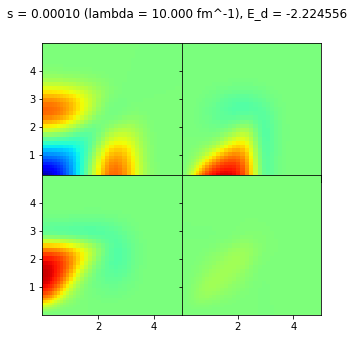

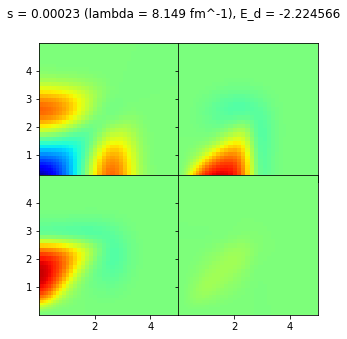

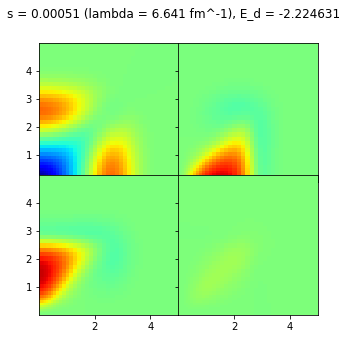

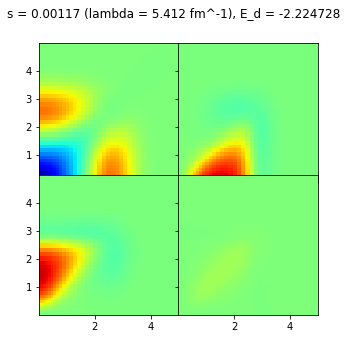

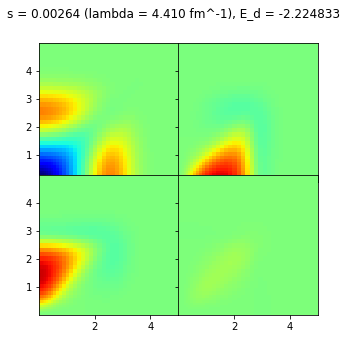

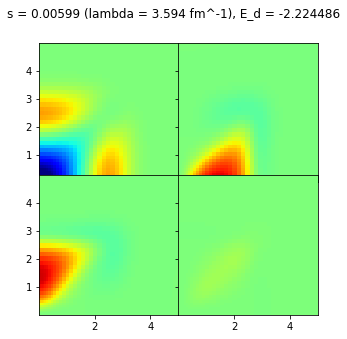

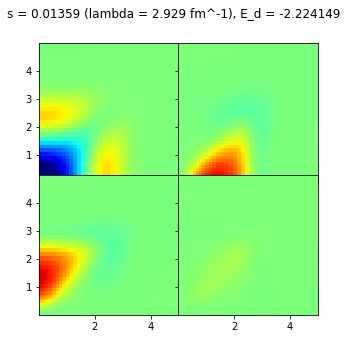

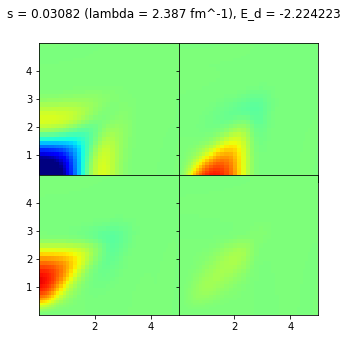

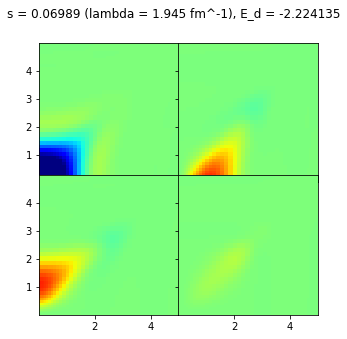

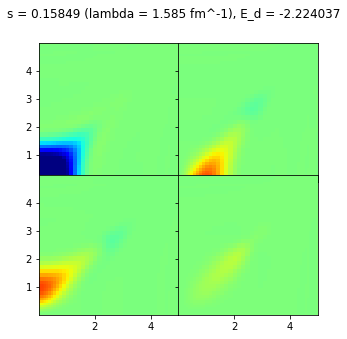

In [23]:
# study matrix elements and check unitarity by investigating deuteron binding energy as a function of RG resolution scale
x0 = np.reshape(sol[0],(2*Nrows,2*Nrows))
PhaseSpace = zeros([Nrows,Nrows])
PhaseSpacecoupled = zeros([2*Nrows,2*Nrows])

for i in range(Nrows):
    for j in range(Nrows):
        PhaseSpace[i,j] = 2.0/np.pi*sqrt(mesh_weights[i]) * sqrt(mesh_weights[j]) * mesh_points[i] * mesh_points[j]
        PhaseSpacecoupled[i,j] = PhaseSpace[i,j]
        PhaseSpacecoupled[i,j+Nrows] = PhaseSpace[i,j]
        PhaseSpacecoupled[i+Nrows,j] = PhaseSpace[i,j]
        PhaseSpacecoupled[i+Nrows,j+Nrows] = PhaseSpace[i,j]

maxindex = Nrows
maxabs = max(abs((x0/PhaseSpacecoupled)[:maxindex,:maxindex].min()),abs(abs((x0/PhaseSpacecoupled)[:maxindex,:maxindex].max())))
for i in range(Ns):
    fig, (ax) = plt.subplots(nrows=2,ncols=2,figsize=(5, 5))
    plt.subplots_adjust(wspace=0.0, hspace=-0.05)
    ax[0,0].set_aspect('equal')
    ax[0,1].set_aspect('equal')
    ax[1,0].set_aspect('equal')
    ax[1,1].set_aspect('equal')
    x = np.reshape(sol[i],(2*Nrows,2*Nrows));
    x00 = x[:Nrows,:Nrows]
    x02 = x[:Nrows,Nrows:2*Nrows]
    x20 = x[Nrows:2*Nrows,:Nrows]
    x22 = x[Nrows:2*Nrows,Nrows:2*Nrows]
    Edeut = solve_deuteron(x00, x02, x20, x22, Nrows) [0];
    title = "s = %.5f (lambda = %.3f fm^-1), E_d = %.6f" % (s[i],Lambda(s[i]),Edeut)
    ax[0,0].pcolormesh(mesh_points[:maxindex], mesh_points[:maxindex], (x00/PhaseSpace)[:maxindex,:maxindex], vmin = -maxabs, vmax = maxabs, cmap='jet',rasterized=True)
    ax[0,1].pcolormesh(mesh_points[:maxindex], mesh_points[:maxindex], (x02/PhaseSpace)[:maxindex,:maxindex], vmin = -maxabs, vmax = maxabs, cmap='jet',rasterized=True)
    ax[1,0].pcolormesh(mesh_points[:maxindex], mesh_points[:maxindex], (x20/PhaseSpace)[:maxindex,:maxindex], vmin = -maxabs, vmax = maxabs, cmap='jet',rasterized=True)
    ax[1,1].pcolormesh(mesh_points[:maxindex], mesh_points[:maxindex], (x22/PhaseSpace)[:maxindex,:maxindex], vmin = -maxabs, vmax = maxabs, cmap='jet',rasterized=True)
    ax[0,1].set_yticklabels([])
    ax[1,1].set_yticklabels([])
    fig.suptitle(title)